## Install required packages

In [ ]:
# Install required package(s)
pkgs <- c("AmesHousing", "dplyr", "faraway", "ggplot2", "MASS", "nnet", "ordinal", "rms", "VGAM")
lib <- installed.packages()[, "Package"]
install.packages(setdiff(pkgs, lib))

## Load some useful packages

In [15]:
library(dplyr)    # for data wrangling
library(ggplot2)  # for plotting

# Set ggplot2 theme for the notebook
theme_set(theme_bw())

## Data exploration

In the code chunk below, we'll load data from the US 1996 national election study and take a peek at the first few rows:

In [17]:
# Load 10 variable subset of US 1996 National Election Study
data(nes96, package = "faraway")

# Print first few rows
head(nes96, n = 10)

,popul,TVnews,selfLR,ClinLR,DoleLR,PID,age,educ,income,vote
,<int>,<int>,<ord>,<ord>,<ord>,<ord>,<int>,<ord>,<ord>,<fct>
1,0,7,extCon,extLib,Con,strRep,36,HS,$3Kminus,Dole
2,190,1,sliLib,sliLib,sliCon,weakDem,20,Coll,$3Kminus,Clinton
3,31,7,Lib,Lib,Con,weakDem,24,BAdeg,$3Kminus,Clinton
4,83,4,sliLib,Mod,sliCon,weakDem,28,BAdeg,$3Kminus,Clinton
5,640,7,sliCon,Con,Mod,strDem,68,BAdeg,$3Kminus,Clinton
6,110,3,sliLib,Mod,Con,weakDem,21,Coll,$3Kminus,Clinton
7,100,7,sliCon,Con,Mod,weakDem,77,Coll,$3Kminus,Clinton
8,31,1,sliCon,Mod,sliCon,indRep,21,Coll,$3Kminus,Clinton
9,180,7,Mod,Con,sliLib,indind,31,Coll,$3Kminus,Clinton


Let's use the `str()` function to print a more useful summary of the `str()`ucture of this data set:

In [18]:
str(nes96)

'data.frame':	944 obs. of  10 variables:
 $ popul : int  0 190 31 83 640 110 100 31 180 2800 ...
 $ TVnews: int  7 1 7 4 7 3 7 1 7 0 ...
 $ selfLR: Ord.factor w/ 7 levels "extLib"<"Lib"<..: 7 3 2 3 5 3 5 5 4 3 ...
 $ ClinLR: Ord.factor w/ 7 levels "extLib"<"Lib"<..: 1 3 2 4 6 4 6 4 6 3 ...
 $ DoleLR: Ord.factor w/ 7 levels "extLib"<"Lib"<..: 6 5 6 5 4 6 4 5 3 7 ...
 $ PID   : Ord.factor w/ 7 levels "strDem"<"weakDem"<..: 7 2 2 2 1 2 2 5 4 1 ...
 $ age   : int  36 20 24 28 68 21 77 21 31 39 ...
 $ educ  : Ord.factor w/ 7 levels "MS"<"HSdrop"<..: 3 4 6 6 6 4 4 4 4 3 ...
 $ income: Ord.factor w/ 24 levels "$3Kminus"<"$3K-$5K"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ vote  : Factor w/ 2 levels "Clinton","Dole": 2 1 1 1 1 1 1 1 1 1 ...


Note that some of the factors are "ordered" by default; for example, take a look at the `educ` variable (respondent's education level):

In [22]:
table(nes96$educ)


    MS HSdrop     HS   Coll  CCdeg  BAdeg  MAdeg 
    13     52    248    187     90    227    127 

Same goes for `PID` (respondent's party identification) and `income`. Does it make sense for these variables to be treated as ordinal?

In [20]:
table(nes96$PID)
table(nes96$income)


 strDem weakDem  indDem  indind  indRep weakRep  strRep 
    200     180     108      37      94     150     175 


  $3Kminus    $3K-$5K    $5K-$7K    $7K-$9K   $9K-$10K  $10K-$11K  $11K-$12K 
        19         12         17         19         18         13         11 
 $12K-$13K  $13K-$14K  $14K-$15K  $15K-$17K  $17K-$20K  $20K-$22K  $22K-$25K 
        17         10         15         23         35         26         39 
 $25K-$30K  $30K-$35K  $35K-$40K  $40K-$45K  $45K-$50K  $50K-$60K  $60K-$75K 
        68         70         62         48         51        100        103 
 $75K-$90K $90K-$105K  $105Kplus 
        53         47         68 

In the next code chunk, we'll clean up the data a bit by:

* condensing `PID` into a new variable (`party`) iwht only three categories;
* convert `income` to numeric by taking the midpoint of each bin (is this a reasonable thing to do?);
* create a new data frame with the variables of interest.

In [23]:
# Condense party identification (PID) column into three categories
party <- nes96$PID
levels(party) <- c(
  "Democrat", "Democrat",
  "Independent", "Independent", "Independent", 
  "Republican", "Republican"
)

# Convert income to numeric
inca <- c(1.5, 4, 6, 8, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 16, 18.5, 21, 23.5,
          27.5, 32.5, 37.5, 42.5, 47.5, 55, 67.5, 82.5, 97.5, 115)
income <- inca[unclass(nes96$income)]

# Construct new data set for analysis
rnes96 <- data.frame(
  "party" = party, 
  "income" = income, 
  "education" = nes96$educ, 
  "age" = nes96$age
)

# Print summary of data set
str(rnes96)

'data.frame':	944 obs. of  4 variables:
 $ party    : Ord.factor w/ 3 levels "Democrat"<"Independent"<..: 3 1 1 1 1 1 1 2 2 1 ...
 $ income   : num  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 ...
 $ education: Ord.factor w/ 7 levels "MS"<"HSdrop"<..: 3 4 6 6 6 4 4 4 4 3 ...
 $ age      : int  36 20 24 28 68 21 77 21 31 39 ...


The next couple of code blocks try to visualize party affiliation by education level and income.

`summarise()` has grouped output by 'education'. You can override using the
`.groups` argument.


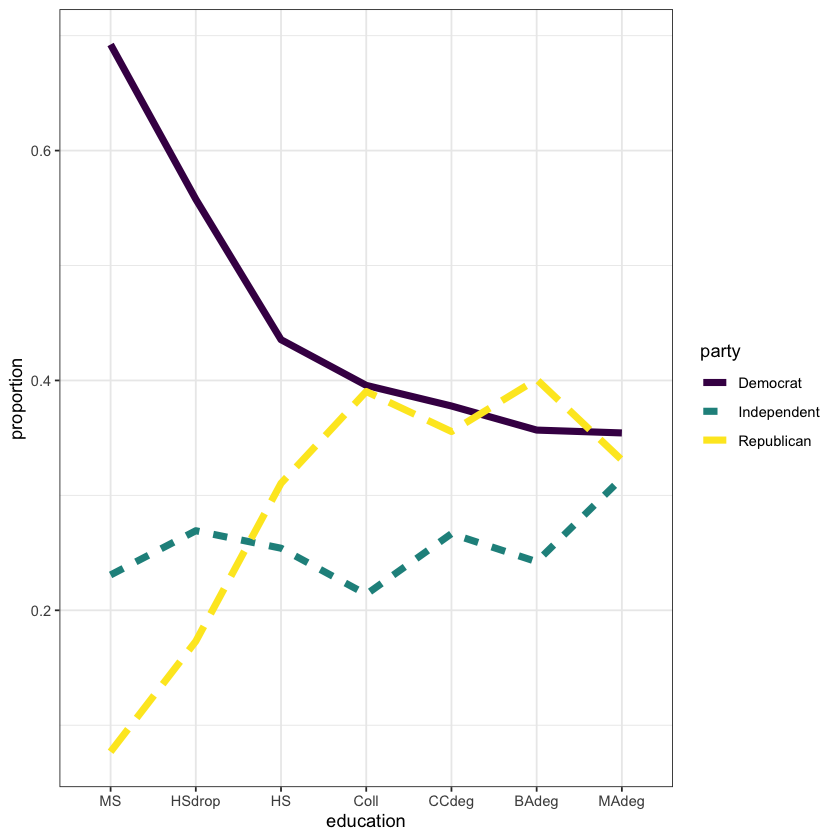

In [24]:
# Aggregate data; what's happening here?
egp <- group_by(rnes96, education, party) %>% 
  summarise(count = n()) %>%
  group_by(education) %>% 
  mutate(etotal = sum(count), proportion = count/etotal)

# Plot results
ggplot(egp, aes(x = education, y = proportion, group = party, 
                linetype = party, color = party)) + 
  geom_line(size = 2)

`summarise()` has grouped output by 'incomegp'. You can override using the
`.groups` argument.


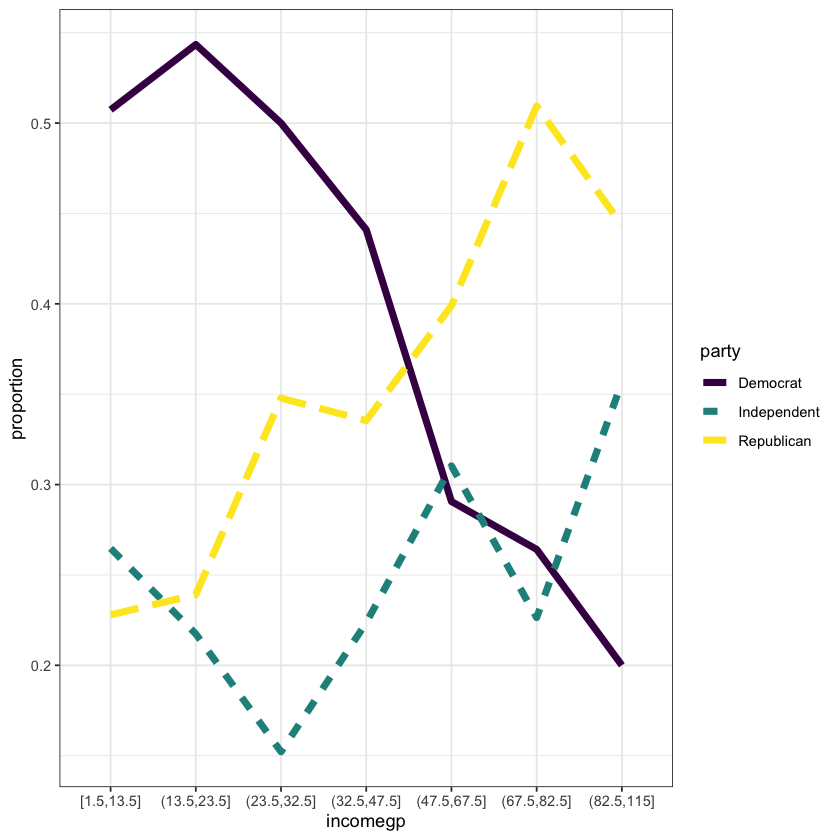

In [25]:
# Aggregate data; what's happening here?
igp <- mutate(rnes96, incomegp = cut_number(income, 7)) %>% 
  group_by(incomegp, party) %>% 
  summarise(count = n()) %>% 
  group_by(incomegp) %>% 
  mutate(etotal = sum(count), proportion = count / etotal)

# Plot results
ggplot(igp, aes(x = incomegp, y  =proportion, group  =party, 
                linetype = party, color = party)) +
  geom_line(size = 2)

## Multinomial logistic model

Define the following probabilities:

* $p_{d} = P\left(\text{voting democrat}\right)$;
* $p_{i} = P\left(\text{voting independent}\right)$;
* $p_{r} = P\left(\text{voting republican}\right)$,

where $p_d + p_i + p_r = 1$. Assume for now that `income` is the only independent variable of interest. The multinomial logit model effectively fits several logits (one for every class except the baseline, which is arbitrary; here, it's democrat):

* $\log\left(p_{i} / p_{d}\right) = \beta_0 + \beta_1 \mathtt{income}\quad$ (log odds of voting independent vs. democrat);
* $\log\left(p_{r} / p_{d}\right) = \alpha_0 + \alpha_1 \mathtt{income}\quad$ (log odds of voting republican vs. democrat).

Here we use $\beta_i$ and $\alpha_i$ to remind us that the estimated coefficients between the two models will be different.

This is somewhat similar to fitting two seperate logit (i.e., logistic regresison) models; akin to a *one-vs-one* aproach. Hence, seperate coefficient estimates for each. For. $J$ classes, we would effectively have $J - 1$ seperate logit models (i.e., sets of different coefficients). 

Below, we use the **nnet** package in R to fit a multinomial logit model to the `rnes96` data.

In [26]:
library(nnet)  # for multinom() and polr() functions

# Fit multinomial log-linear model; see ?nnet::multinom for details
(fit.multi <- multinom(party ~ age + education + income, data = rnes96))

# weights:  30 (18 variable)
initial  value 1037.090001 
iter  10 value 990.568608
iter  20 value 984.319052
final  value 984.166272 
converged


Call:
multinom(formula = party ~ age + education + income, data = rnes96)

Coefficients:
            (Intercept)          age education.L education.Q education.C
Independent   -1.197260 0.0001534525  0.06351451  -0.1217038   0.1119542
Republican    -1.642656 0.0081943691  1.19413345  -1.2292869   0.1544575
            education^4 education^5 education^6     income
Independent -0.07657336   0.1360851  0.15427826 0.01623911
Republican  -0.02827297  -0.1221176 -0.03741389 0.01724679

Residual Deviance: 1968.333 
AIC: 2004.333 

In [28]:
# Fit multinomial log-linear model with education as a nominal factor
rnes96_2 <- rnes96
rnes96_2$education <- factor(rnes96_2$education, ordered = FALSE)
multinom(party ~ age + education + income, data = rnes96_2)

# weights:  30 (18 variable)
initial  value 1037.090001 
iter  10 value 990.364722
iter  20 value 984.508641
final  value 984.166272 
converged


Call:
multinom(formula = party ~ age + education + income, data = rnes96_2)

Coefficients:
            (Intercept)          age educationHSdrop educationHS educationColl
Independent   -1.373895 0.0001539014       0.2704482   0.2458744    0.09119446
Republican    -3.048576 0.0081945031       0.9876547   1.6915600    1.95336096
            educationCCdeg educationBAdeg educationMAdeg     income
Independent      0.3269554      0.1082654      0.1933497 0.01623914
Republican       1.8835335      1.8708213      1.4539589 0.01724696

Residual Deviance: 1968.333 
AIC: 2004.333 

What happened to `educucation`, and why did it not get dummy encoded? 

## Brief (non-math) digression into orthogonal polynomial encoding

Orthogonal polynomial (OP) encoding for factors helps look for the linear, quadratic, and cubic trends in the categorical variable of interest (see plots below). Note that OP encoding should only be used with an ordinal variable in which the levels are *equally spaced* (e.g., income or education).  

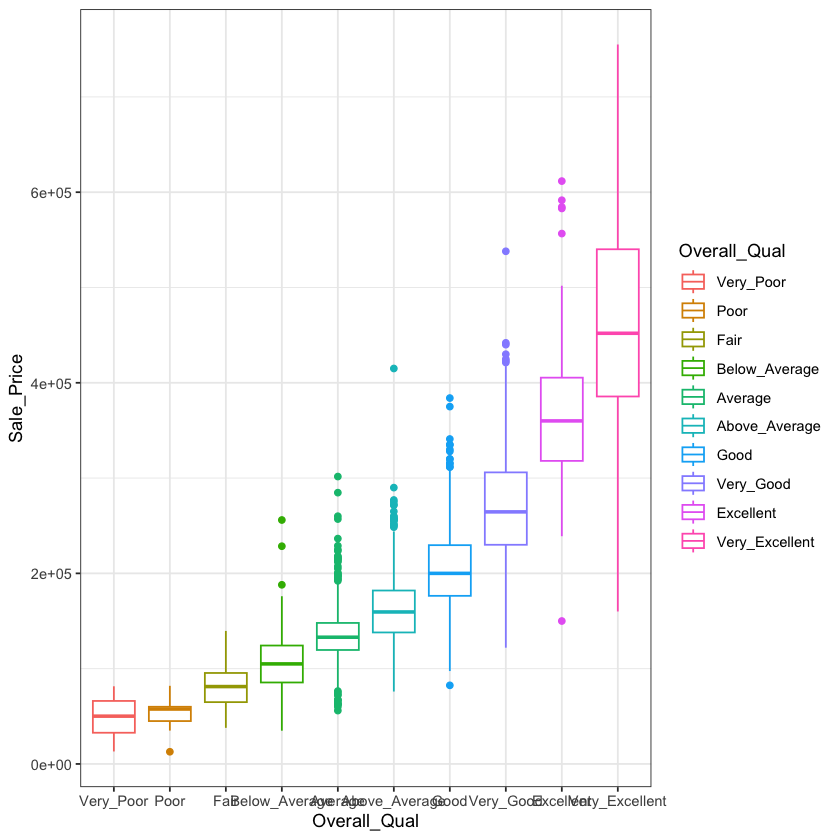

In [27]:
ames <- AmesHousing::make_ames()
ggplot(ames, aes(x = Overall_Qual, y = Sale_Price)) +#log(Sale_Price))) +
  geom_boxplot(aes(color = Overall_Qual))

In [ ]:
summary(lm(log(Sale_Price) ~ Overall_Qual, data = ames))

In [ ]:
ames.ord <- AmesHousing::make_ordinal_ames()
summary(lm(log(Sale_Price) ~ Overall_Qual, data = ames.ord))

In [ ]:
# What if we ignore the log scale?
ggplot(ames, aes(x = Overall_Qual, y = Sale_Price)) +
  geom_boxplot(aes(color = Overall_Qual))
summary(lm(Sale_Price ~ Overall_Qual, data = ames))
summary(lm(Sale_Price ~ Overall_Qual, data = ames.ord))

## End digression...

In [ ]:
summary(fit.multi)  # no p-values here

In [ ]:
# How do we interpret the coefficients? For example, (all else held constant) for every one-unit increase
# in income, the multinomial log odds of voting republican, relative to democrat,
# increase by 0.003.
#
# Gross...
#
# Effect plots to the rescue!

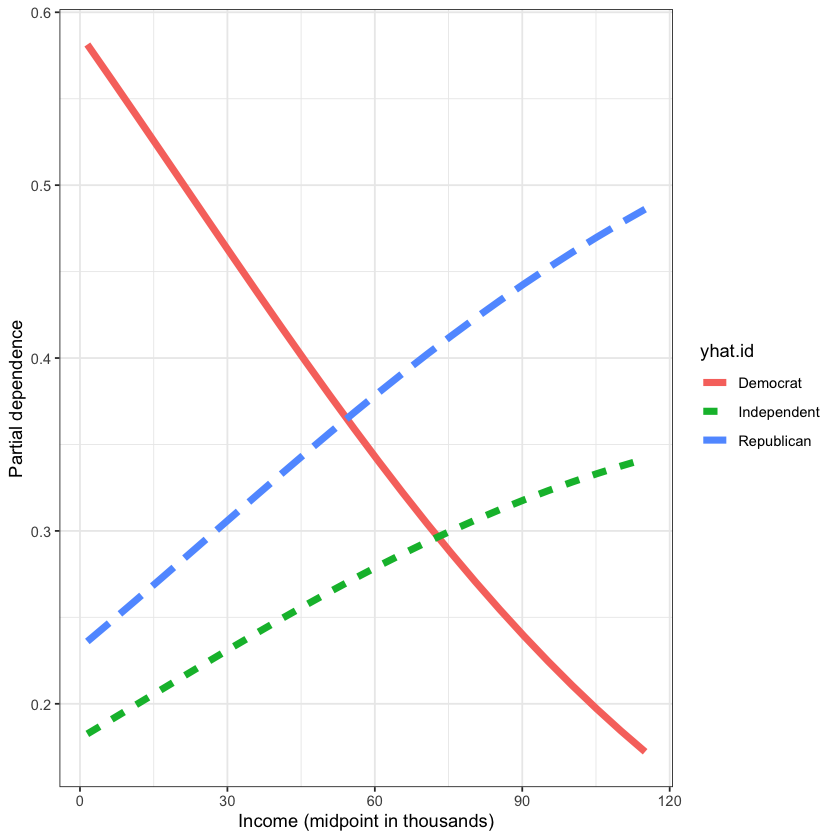

In [29]:
library(pdp)  # for partial dependence (PD) plots

# Compute partial dependence of party identification on income
pfun <- function(object, newdata) {
  probs <- predict(object, newdata = newdata, type = "probs")
  colMeans(probs)  # return 
}
pd.inc <- partial(fit.multi, pred.var = "income", pred.fun = pfun)
ggplot(pd.inc, aes(x = income, y = yhat, linetype = yhat.id, color = yhat.id)) +
  geom_line(size = 2) +
  xlab("Income (midpoint in thousands)") +
  ylab("Partial dependence")

In [30]:
# Try stepwise; since the model is based on a (multinomial) likelihood, the AIC/BIC 
# are well-defined and the usual stepwise procedures are still valid 
MASS::stepAIC(fit.multi, direction = "both", scope = list("upper" = ~.^2))

Start:  AIC=2004.33
party ~ age + education + income

# weights:  27 (16 variable)
initial  value 1037.090001 
iter  10 value 988.896864
iter  20 value 985.822223
final  value 985.812737 
converged
# weights:  12 (6 variable)
initial  value 1037.090001 
iter  10 value 992.269502
final  value 992.269484 
converged
# weights:  27 (16 variable)
initial  value 1037.090001 
iter  10 value 1009.025560
iter  20 value 1006.961593
final  value 1006.955275 
converged
# weights:  48 (30 variable)
initial  value 1037.090001 
iter  10 value 1004.992102
iter  20 value 981.097880
iter  30 value 974.672766
iter  40 value 974.632373
iter  40 value 974.632372
iter  40 value 974.632372
final  value 974.632372 
converged
# weights:  33 (20 variable)
initial  value 1037.090001 
iter  10 value 989.133986
iter  20 value 983.452423
final  value 983.369209 
converged
# weights:  48 (30 variable)
initial  value 1037.090001 
iter  10 value 1002.858283
iter  20 value 980.366035
iter  30 value 976.643913
final  va

Call:
multinom(formula = party ~ income, data = rnes96)

Coefficients:
            (Intercept)     income
Independent  -1.1749331 0.01608683
Republican   -0.9503591 0.01766457

Residual Deviance: 1985.424 
AIC: 1993.424 

In [31]:
# Look at predicted probabilities
head(predict(fit.multi, type = "probs"))

,Democrat,Independent,Republican
1,0.5923052,0.1975326,0.2101622
2,0.5919378,0.1687055,0.2393567
3,0.5970789,0.1732058,0.2297154
4,0.5924809,0.1719775,0.2355417
5,0.5423563,0.1583973,0.2992464
6,0.5907590,0.1683954,0.2408456


In [ ]:
proportions(table(rnes96$party))

,education,yhat,yhat.id
,<ord>,<dbl>,<chr>
1,MS,0.5847048,Democrat
2,HSdrop,0.4725179,Democrat
3,HS,0.4009031,Democrat
4,Coll,0.3796768,Democrat
5,CCdeg,0.3688061,Democrat
6,BAdeg,0.3900266,Democrat


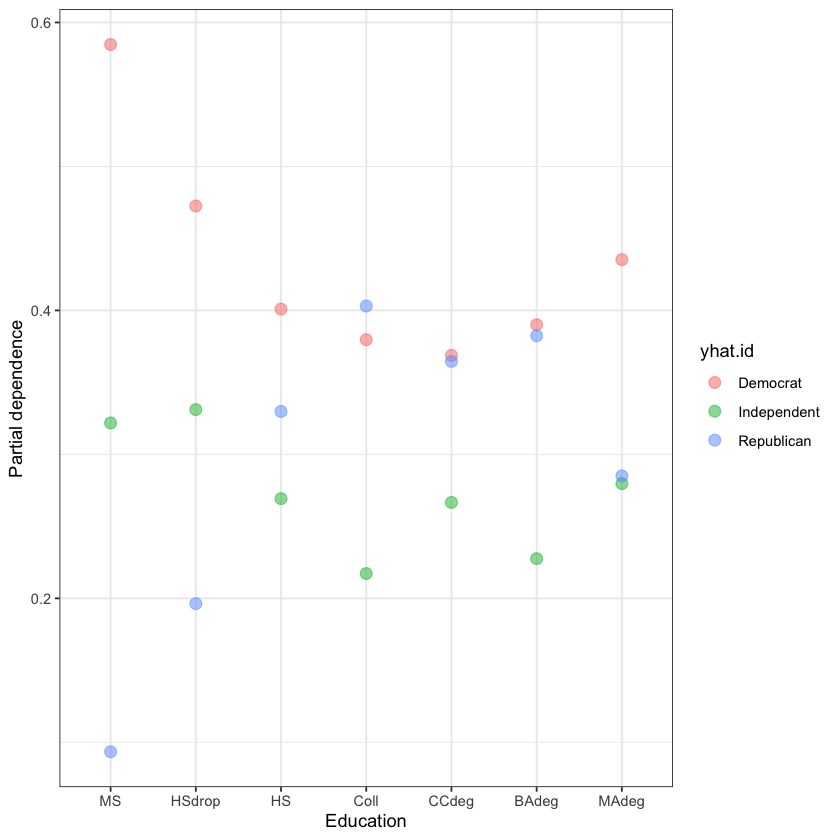

In [32]:
# Construct partial dependence of party affiliation on education
pd.edu <- partial(fit.multi, pred.var = "education", pred.fun = pfun)
head(pd.edu)
ggplot(pd.edu, aes(x = education, y = yhat, linetype = yhat.id, color = yhat.id)) +
  geom_point(size = 3, alpha = 0.5) +
  xlab("Education") +
  ylab("Partial dependence") 

In [33]:
# Can perform classification, if desired (insert eyeroll emoji...)
table("Predicted" = predict(fit.multi), "Actual" = rnes96$party)
# Ummm...majority of actual Republicans are classified as Democrats

             Actual
Predicted     Democrat Independent Republican
  Democrat         277         130        169
  Independent        4           7          5
  Republican        99         102        151

In [ ]:
# For comparison, fit a (default) random forest (RF); see 
# ?randomForest::randomForest for additional details
set.seed(2008)  # for reproducibility
(fit.rfo <- randomForest::randomForest(party ~ ., data = rnes96, ntree = 1000))

In [ ]:
# Construct the same PD plot as before, but using the RF model
pd.rfo <- partial(fit.rfo, pred.var = "income", pred.fun = function(object, newdata) {
  colMeans(predict(object, newdata = newdata, type = "prob"))
})
ggplot(pd.rfo, aes(x = income, y = yhat, linetype = yhat.id, color = yhat.id)) +
  geom_line(size = 2) +
  xlab("Income (midpoint in thousands)") +
  ylab("Partial dependence") +
  geom_rug(data = data.frame("income" = quantile(rnes96$income, prob = 1:9/10)),
           aes(x = income), inherit.aes = FALSE)

## Proportional odds cummulative logit model

For an ordered outcome with $J$ categories $1 < 2 < 3 < \cdots < J$, the *proportional odds cummulative logit* (PO, for short) models fits a logit-type model using the cumulative probabilities. For brevity, let 

* $p_{\le j} = P\left(Y \le j | \boldsymbol{x}\right)$;
* $p_{> j} = P\left(Y > j | \boldsymbol{x}\right)$.

The PO model uses the following logit:

$\log\left(\frac{p_{\le j}}{p_{>j}}\right) = \alpha_j + \boldsymbol{x}^\top\boldsymbol{\beta}$.

It's worth noting that for the non-proportional odds cummulative logit (NPO, for short) model:

$\log\left(\frac{p_{\le j}}{p_{>j}}\right) = \alpha_j + \boldsymbol{x}^\top\boldsymbol{\beta}_j$.

That is, in the NPO model, the $\beta$ coefficients depend on $j$. In short, the PO model has a simpler form since only the inetrcepts are allowed to vary (hence, proportional odds assumption). 

In [ ]:
###############################################################################
#
# Modeling ordinal data using the proportional odds (PO) model
#
# Reference: https://journal.r-project.org/archive/2018/RJ-2018-004/RJ-2018-004.pdf
#
###############################################################################

In [34]:
library(MASS)  # for polr() function; already loaded but listed here again

# The following packages offer similar functionality
#library(rms)
#library(ordinal)
#library(VGAM)  # used in Dr. Liu's slides and videos

# This is the log odds of category k or less, and since these are log odds 
# which differ only by a constant for different k, the odds are proportional. 
# Hence the term proportional odds logistic regression.

# Fit a proportional odds logistic regression
(fit.polr <- polr(party ~ age + education + income, data = rnes96))


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




Call:
polr(formula = party ~ age + education + income, data = rnes96)

Coefficients:
         age  education.L  education.Q  education.C  education^4  education^5 
 0.005774902  0.724086814 -0.781360508  0.040168238 -0.019925492 -0.079412657 
 education^6       income 
-0.061103738  0.012738693 

Intercepts:
  Democrat|Independent Independent|Republican 
             0.6448794              1.7373541 

Residual Deviance: 1984.211 
AIC: 2004.211 

In [35]:
# Predicted (non-cumulative) probabilities
head(predict(fit.polr, newdata = rnes96, type = "probs"))

,Democrat,Independent,Republican
1,0.5673361,0.2289862,0.2036777
2,0.5346171,0.2394053,0.2259776
3,0.5428780,0.2369062,0.2202158
4,0.5371401,0.2386517,0.2242082
5,0.4794712,0.2536103,0.2669185
6,0.5331800,0.2398307,0.2269893


## Interpreting the coefficients

![](https://media.giphy.com/media/dBsUACbhvDROt9pbFO/giphy.gif)

Take a look at **Table 2** in this [paper](https://journal.r-project.org/archive/2018/RJ-2018-004/RJ-2018-004.pdf). Once you know which parameterization your software uses for the PO/NPO model, then you should be able to interpret the coefficient estimates in the right direction.

In [ ]:
# One interprets the effects in the PO model using ordinary odds ratios. The 
# difference is that a single odds ratio is assumed to apply equally to *all*
# events Y<=j (or Y>=j, depending on software), j=1,2,...,k. If linearity and additivity hold, exp(beta_m) is 
# the odds of Y<=j (regardless of j) for every one-unit increase in X_m.

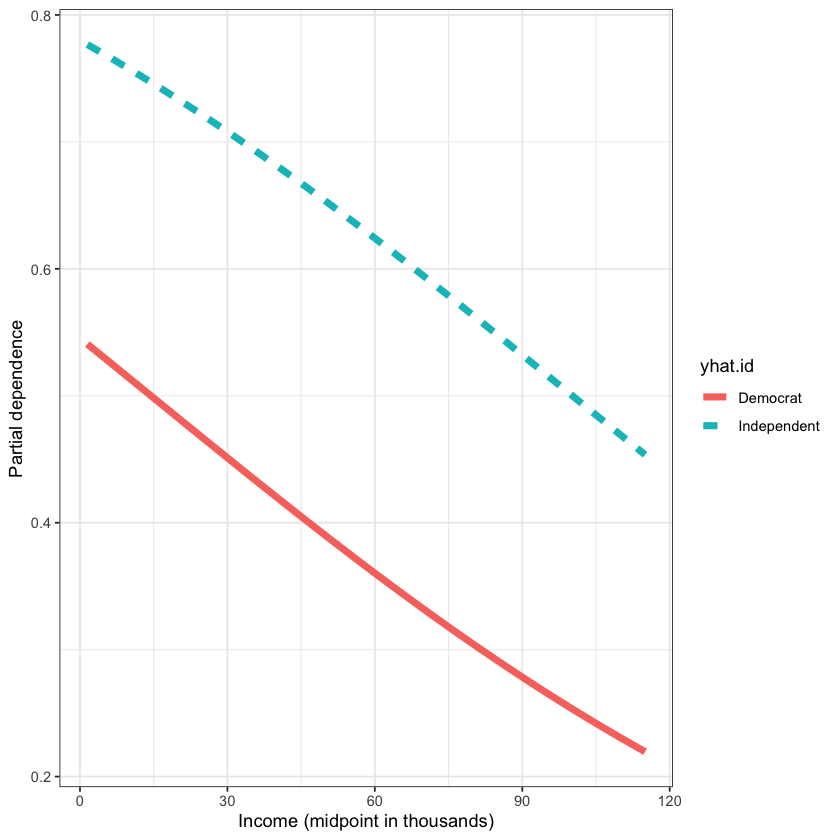

In [36]:
# Just look at effect plots...
pfun <- function(object, newdata) {
  probs <- predict(object, newdata = newdata, type = "probs")  # individual probs
  cprobs <- t(apply(probs[, 1:2], MARGIN = 1, FUN = cumsum))  # cumulative probs
  colMeans(cprobs)  # return averaged predicted probs for each class
}
pd.inc <- partial(fit.polr, pred.var = "income", pred.fun = pfun)
ggplot(pd.inc, aes(x = income, y = yhat, linetype = yhat.id, color = yhat.id)) +
  geom_line(size = 2) +
  xlab("Income (midpoint in thousands)") +
  ylab("Partial dependence")

In [37]:
# Try stepwise
stepAIC(fit.polr, direction = "both")

Start:  AIC=2004.21
party ~ age + education + income

            Df    AIC
- education  6 2002.8
<none>         2004.2
- age        1 2004.4
- income     1 2038.6

Step:  AIC=2002.83
party ~ age + income

            Df    AIC
- age        1 2001.4
<none>         2002.8
+ education  6 2004.2
- income     1 2047.2

Step:  AIC=2001.36
party ~ income

            Df    AIC
<none>         2001.4
+ age        1 2002.8
+ education  6 2004.4
- income     1 2045.3


Call:
polr(formula = party ~ income, data = rnes96)

Coefficients:
    income 
0.01311984 

Intercepts:
  Democrat|Independent Independent|Republican 
             0.2091045              1.2915566 

Residual Deviance: 1995.363 
AIC: 2001.363 

In [ ]:
library(VGAM)  # for vglm() function

# Fit different models; some of these are the same, but use a different 
# parameterization...
(fit1 <- vglm(party ~ age + education + income,  # uses P(Y <= j),
              family = propodds(reverse = FALSE), data = rnes96))  
(fit2 <- vglm(formula = party ~ age + education + income,  # same as above, but uses P(Y >= j)
              family = propodds(reverse = TRUE), data = rnes96))
(fit3 <- vglm(formula = party ~ age + education + income, 
              family = cumulative(parallel = TRUE), data = rnes96))
(fit4 <- vglm(formula = party ~ age + education + income,  # same as above (and with polr())
              family = cumulative(parallel = FALSE), data = rnes96))

In [ ]:
# A basic assumption of all commonly used ordinal regression models is that 
# the response variable behaves in an ordinal fashion. 

Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




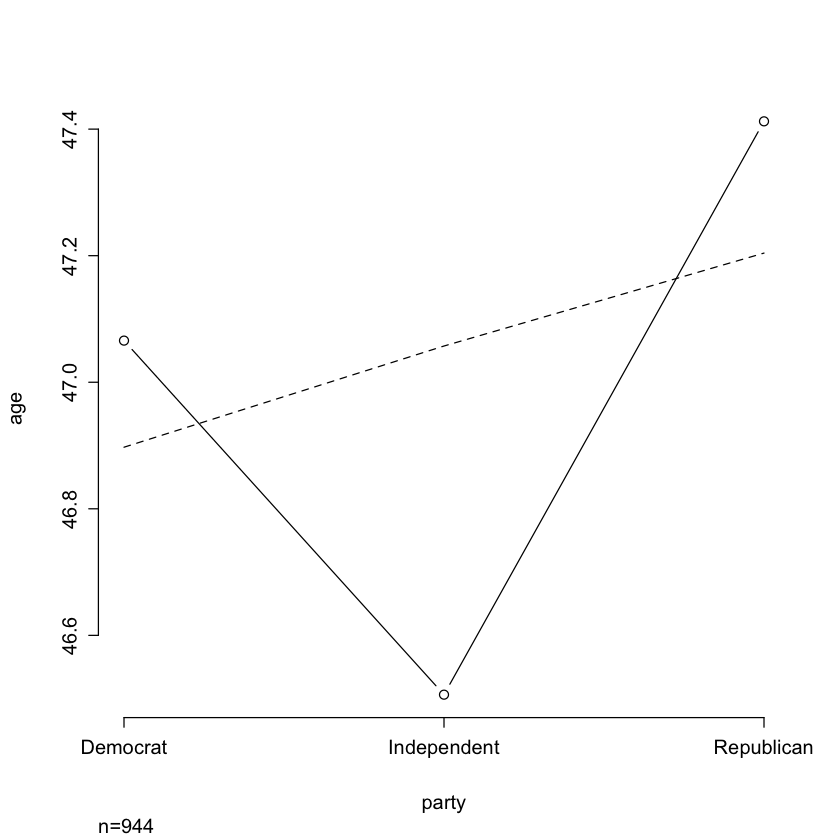

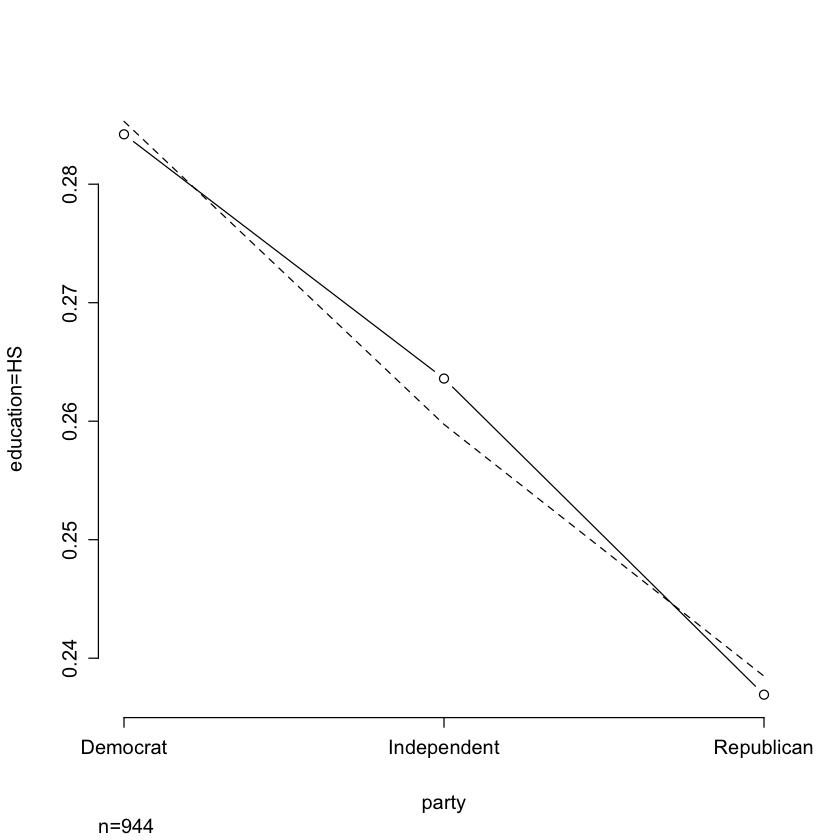

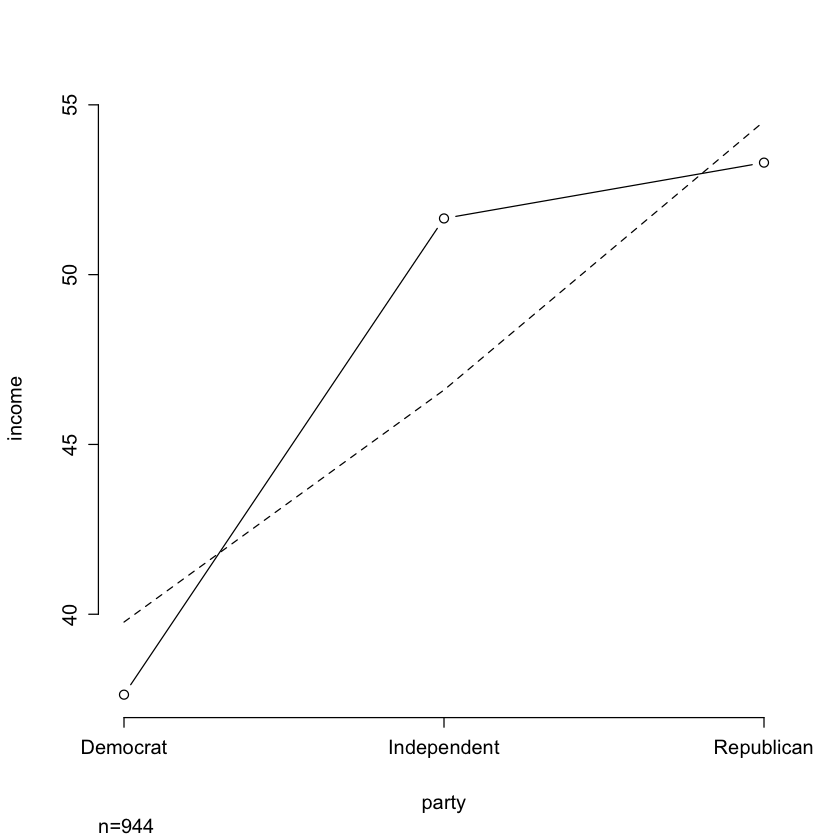

In [39]:
# ?rms::plot.xmean.ordinaly
#
# Separately for each predictor variable X in a formula, plots the mean of X 
# vs. levels of Y. Then under the proportional odds assumption, the expected 
# value of the predictor for each Y value is also plotted (as a dotted line). 
# This plot is useful for assessing the ordinality assumption for Y separately 
# for each X, and for assessing the proportional odds assumption in a simple 
# univariable way. If several predictors do not distinguish adjacent categories 
# of Y, those levels may need to be pooled. This display assumes that each 
# predictor is linearly related to the log odds of each event in the 
# proportional odds model. There is also an option to plot the expected means 
# assuming a forward continuation ratio model.
library(rms)

# plot mean of each x vs. ordinal y (assumes each x is linearly related to y)
rms::plot.xmean.ordinaly(party ~ age + education + income, data = rnes96)

In [40]:
# Fit model the PO model using rms package
#options()$contrasts
(fit.orm <- orm(party ~ age + education + income, data = rnes96))


ERROR: Error in Design(X, formula = formula): Variable education is an ordered factor with non-numeric levels.
 You should set options(contrasts=c("contr.treatment", "contr.treatment"))
or rms will not work properly.


In [41]:
# WTF?
#
# Fine...
options(contrasts = c("contr.treatment", "contr.treatment"))  # I guess rms does not like ordered factors...

# Refit the model and treat all categorical variables as nominal
(fit.orm <- orm(party ~ age + education + income, data = rnes96))

Logistic (Proportional Odds) Ordinal Regression Model

orm(formula = party ~ age + education + income, data = rnes96)

                        Model Likelihood               Discrimination    Rank Discrim.    
                              Ratio Test                      Indexes          Indexes    
Obs            944    LR chi2      57.06    R2                  0.066    rho     0.245    
 Democrat      380    d.f.             8    R2(8,944)           0.051                     
 Independent   239    Pr(> chi2) <0.0001    R2(8,828.6)         0.057                     
 Republican    325    Score chi2   56.58    |Pr(Y>=median)-0.5| 0.116                     
Distinct Y       3    Pr(> chi2) <0.0001                                                  
Median Y         2                                                                        
max |deriv| 0.0002                                                                        

                 Coef    S.E.   Wald Z Pr(>|Z|)
y>=Independen

In [ ]:
# Exponentiating gives the multiplicative increase to P(Y>j|x), for j=Dem<Mod<Rep
exp(coef(fit.orm))

For example, for every "midpoint increase" in income, the odds of voting republican or independent over democrat increase by  1.3%.

In [42]:
# More options when requesting predictions from an ordinal regression model
head(p1 <- predict(fit.orm, type = "fitted"))  # cumulative probabilities
head(p2 <- predict(fit.orm, type = "fitted.ind"))  # individual probabilities

,y>=Independent,y>=Republican
1,0.4326639,0.2036775
2,0.4653843,0.2259784
3,0.4571215,0.2202153
4,0.4628592,0.2242075
5,0.5205267,0.2669167
6,0.4668214,0.2269900


,party=Democrat,party=Independent,party=Republican
1,0.5673361,0.2289864,0.2036775
2,0.5346157,0.2394059,0.2259784
3,0.5428785,0.2369062,0.2202153
4,0.5371408,0.2386517,0.2242075
5,0.4794733,0.2536101,0.2669167
6,0.5331786,0.2398313,0.2269900


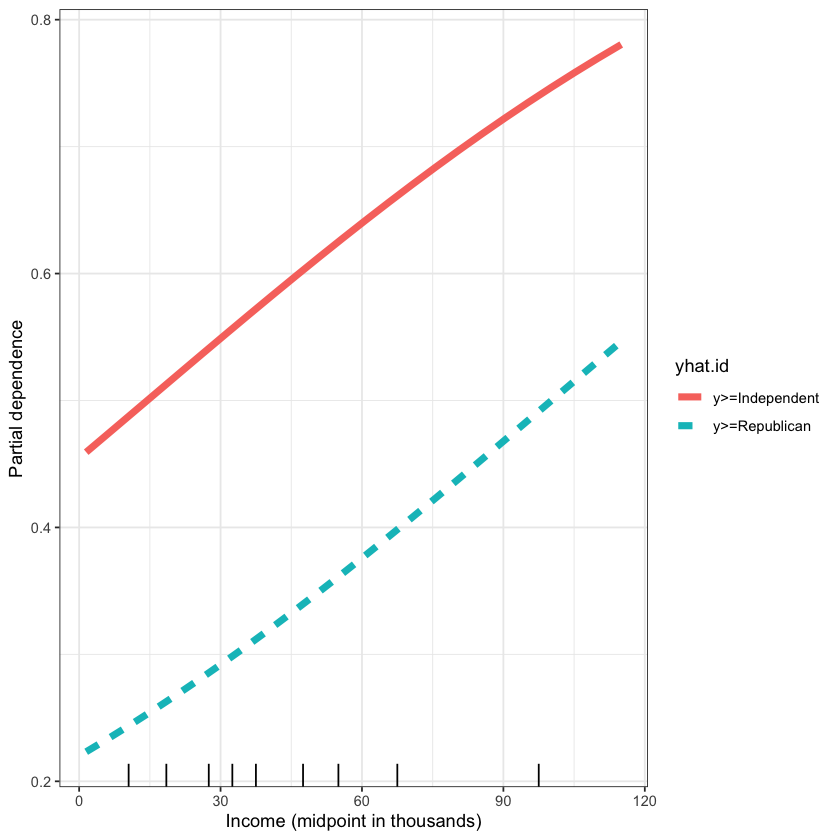

In [43]:
# Let's make a simple feature effect (e.g., a partial dependence) plot
pfun.orm <- function(object, newdata) {
  colMeans(predict(object, newdata = newdata, type = "fitted"))
}
pd.income <- partial(fit.orm, pred.var = "income", pred.fun = pfun.orm)
ggplot(pd.income, aes(x = income, y = yhat, linetype = yhat.id, color = yhat.id)) +
  geom_line(size = 2) +
  xlab("Income (midpoint in thousands)") +
  ylab("Partial dependence") +
  geom_rug(data = data.frame("income" = quantile(rnes96$income, prob = 1:9/10)),
           aes(x = income), inherit.aes = FALSE)